# Analysis of CISM-CLM coupling intrinsics <br>using history and coupler output from a dedicated T31 run

This notebook uses output from this simulation

```python
/glade/u/home/lvank/cesm/my_cases/cmip6_Icomp/I2000_T31_test
```

which is a I2000 simulation at T31 resolution with these settings:

> **user_nl_cpl**
```
histaux_l2x1yrg = .true.
do_histinit = .true.
glc_renormalize_smb = 'on'
```


> **user_nl_clm**
```
hist_empty_htapes = .true.
hist_nhtfrq = -24
hist_fincl1 = 'ICE_MODEL_FRACTION','PCT_LANDUNIT', 'PCT_GLC_MEC', 'QICE', 'QICE_FORC', 'TOPO_FORC', 'TSRF_FORC'
```

There is 2 years of output. 

In [1]:
import numpy as np
import math
import sys,os
import xarray as xr

from netCDF4 import Dataset, default_fillvals
from datetime import datetime

import matplotlib.pyplot as plt

In [2]:
# some constants
rhoi= 0.917e3 # kg/m3
rhow= 1.000e3

fac_Gt = 1e-12  # kg
fac_km2 = 1e6   # m

sec_in_year = 365 * 86400.

dpm = np.asarray(( 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31)) # days per month

# Step 1 - Read data

## CLM (time-average)

In [3]:
#datadir = "/glade/scratch/lvank/archive/I2000_T31_test/"
datadir = "/glade/u/home/lvank/work/projects/reconcile_smb/archive/I2000_T31_test/"

filename1 = "all_0001.nc"
filename2 = "all_0002.nc"

In [4]:
ds1 = xr.open_dataset(os.path.join(datadir, 'lnd', 'hist', filename1), decode_times=False)
ds2 = xr.open_dataset(os.path.join(datadir, 'lnd', 'hist', filename2), decode_times=False)

In [5]:
ds1_tmean = ds1.mean(dim='time')
ds2_tmean = ds2.mean(dim='time')

/glade/u/home/lvank/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


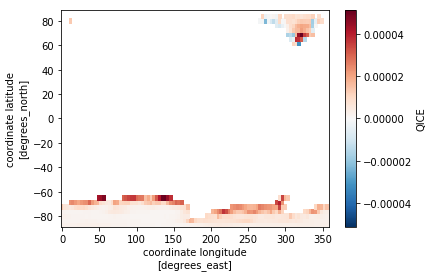

In [6]:
ds1_tmean.QICE.plot()

Read some static CLM-specifics, and give short-hands.

In [73]:
with ds1_tmean as ds:
    imf = ds['ICE_MODEL_FRACTION'][:,:].load()
    plu = ds['PCT_LANDUNIT'][3,:,:].load()
    lf = ds['landfrac']
    area = ds['area']


Using these shorthands, construct the "GrIS mask" that Leo is typically using for mass integrations.

In [8]:


### GRIS EXTENT: ICE_MODEL_FRACTION
gris_mask_A = imf * plu * 0.01 

### GRIS EXTENT: MINIMUM OF LANDFRAC AND ICE_MODEL_FRACTION
min_lf = xr.where(lf<imf, lf, imf)
gris_mask_B = min_lf * plu * 0.01 

gris_mask_C = min_lf

#mma = gris_mask_B * area
#print('GrIS area extent: ',mma.sum().item())

## Coupler (time-average)

In [9]:
filename1 = "I2000_T31_test.cpl.ha.0001.nc"
filename2 = "I2000_T31_test.cpl.ha.0002.nc"

print(os.path.join(datadir, 'cpl', 'hist', filename2))

ds1x = xr.open_dataset(os.path.join(datadir, 'cpl', 'hist', filename1), decode_times=False)
ds2x = xr.open_dataset(os.path.join(datadir, 'cpl', 'hist', filename2), decode_times=False)

with ds2x as ds:

    #foo = ds.g2x_Sg_icemask_coupled_fluxes[0]
    #bar = ds.g2x_Sg_icemask[0]
    #ic = ds.g2x_Sg_ice_covered[0]
    
    # cell area from model
    glc_area1 = ds.domg_area.squeeze()
    lnd_area1 = ds.doml_area.squeeze()
    
    # cell area from mapping file
    glc_area2 = ds.domg_aream.squeeze()
    lnd_area2 = ds.doml_aream.squeeze()

    lnd_frac = ds.doml_frac.squeeze()
    lnd_mask = ds.doml_mask.squeeze()
    
    glc_frac = ds.domg_frac.squeeze()
    glc_mask = ds.domg_mask.squeeze()

/glade/u/home/lvank/work/projects/reconcile_smb/archive/I2000_T31_test/cpl/hist/I2000_T31_test.cpl.ha.0002.nc


The two land area definitions are interchangeable:

In [10]:
np.allclose(lnd_area1.to_masked_array(), lnd_area2.to_masked_array())

True

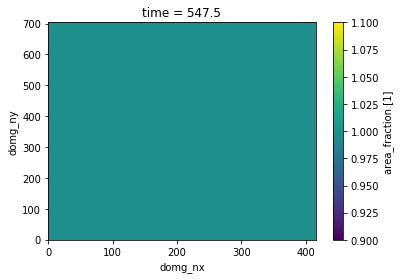

In [11]:
#lnd_frac.plot()
glc_frac.plot()

CLM's `landfrac` is identical to the coupler field `doml_frac`:

In [12]:
np.allclose(lf.to_masked_array(), lnd_frac.to_masked_array())

True

Convert coupler area in rad$^2$ to km$^2$.

In [13]:
## Load utilily library

# IPython extension to reload modules before executing user code.
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload

%aimport libutil

# Reload all modules imported with %aimport every time before executing the Python code typed.
%autoreload 1

In [14]:
glc_area_km1 = libutil.area_rad_to_km(glc_area1) # cell area from model
glc_area_km2 = libutil.area_rad_to_km(glc_area2) # cell area from mapping file
lnd_area_km = libutil.area_rad_to_km(lnd_area1)

## CISM (time-average)

In [15]:
filename1 = "I2000_T31_test.cism.h.0002-01-01-00000.nc"
filename2 = "I2000_T31_test.cism.h.0003-01-01-00000.nc"

ds1g = xr.open_dataset(os.path.join(datadir, 'glc', 'hist', filename1), decode_times=False)
ds2g = xr.open_dataset(os.path.join(datadir, 'glc', 'hist', filename2), decode_times=False)

# Step 2 - Comparisons

## Ice sheet grid mask ("Sg_icemask")

The “ice sheet grid mask” tells CLM where CISM is active, and where it potentially can send SMB. Typically this mask is 1 over mainland Greenland, and 0 over open ocean and other landmasses (e.g. Ellesmere). 


* ice mask in CISM : `usurf > 0`
* ice mask in CPL-G : `g2xavg_Sg_icemask`
* ice mask in CPL-L : `x2lavg_Sg_icemask`
* ice cover in CLM: `ICE_MODEL_FRACTION`

**Local domain**
<br>
On the CISM side, we have two definitions. In CISM the ice mask grid mask is defined as `usurf>0` and in the coupler this is called `Sg_icemask`. The next cell proves that they are equal. 

In [16]:
gIceMask = xr.where(ds2g['usurf'].squeeze() > 0, 1,0 )
xgIceMask = ds1x['g2xavg_Sg_icemask'].squeeze()
np.allclose(gIceMask.values, xgIceMask.values)

True

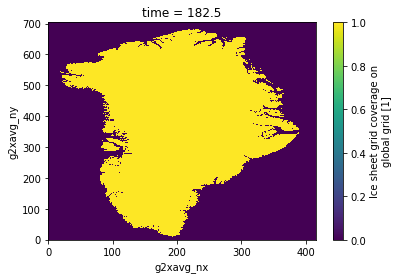

In [17]:
xgIceMask.plot()

**Global domain**
<br>
CLM's `ICE_MODEL_FRACTION` has already been imported as `imf`.  We are comparing this to the coupler-L field `x2lavg_Sg_icemask`

In [18]:
xlIceMask = ds1x['x2lavg_Sg_icemask'].squeeze()
np.allclose(imf.to_masked_array(), xlIceMask.to_masked_array())

True

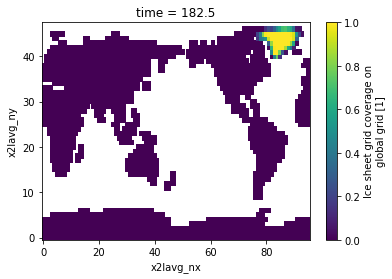

In [19]:
xlIceMask.plot()

**Conservation**
<br>
To investigate area conservation of this field, we will be multiplying with the area in km$^2$. 

In [20]:
### Area of CPL-G ice mask
print('CISM, area definition A:', (gIceMask.values * glc_area_km1.values).sum())
print('CISM, area definition B:', (gIceMask.values * glc_area_km2.values).sum())

### Area of CPL-L ice mask
print('CLM, no correction:', (xlIceMask.to_masked_array() * lnd_area_km.values).sum())
print('CLM, landfrac correction:', (xlIceMask.to_masked_array() * lnd_area_km.values * lnd_frac).sum())

### Minimum of CPL-L ice mask and landfrac
print('CLM, min(landfrac, *):', (min_lf.to_masked_array() * lnd_area_km.values).sum())

CISM, area definition A: 2184256.0
CISM, area definition B: 2191143.1616609427
CLM, no correction: 2212744.636371046
CLM, landfrac correction: 1931573.4012404273
CLM, min(landfrac, *): 2180684.281047856


There seems to be no area conservation of this field, using the areas from the coupler.  

In one of his emails, Bill S. already alluded to the fact that the coupler projections may not be area-conserving:

>If I remember the context of this, then no, using the actual areas isn't enough: Conservation errors from the remapping are due not just to the area differences but also to the use of remapping methods that are not conservative, both in the horizontal (bilinear) and vertical.

which could explain what we are seeing here.

In [21]:
2212744.6 / 2191143 * 100

100.98585989139002

## Glacier area ("ice covered")

The glacier / ice cover tells CLM where there is ice present in CISM. This is a binary field in CISM (0/1) and fractional in CLM. In one-way coupled runs, this field is only send once to CLM, i.e. at the start of the simulation. 

From the [User Guide](https://escomp.github.io/cism-docs/cism-in-cesm/versions/release-cesm2.0/html/clm-cism-coupling.html):
>Over the CISM domain (typically Greenland in CESM2), CISM dictates glacier areas and topographic elevations, overriding the values on CLM’s surface dataset. 

* glacier cover in CISM : where thk > 0 
* glacier cover in CPL-g : binary field `g2x_Sg_ice_covered`
* glacier cover in CPL-l : fractional fields `x2lavg_Sg_ice_covered00`, ...
* glacier cover in CLM: PCT_LANDUNIT(3)

**Local domain**
<br>
On the CISM side, we have two definitions. In CISM the ice mask grid mask is defined as `thk>0` and in the coupler this is called `Sg_ice_covered`. The next cell proves that they are equal. 

In [22]:
gIceCov = xr.where(ds2g['thk'].squeeze() > 0, 1,0 )
xgIceCov = ds2x['g2xavg_Sg_ice_covered'].squeeze()
np.allclose(gIceCov.values, xgIceCov.values)

True

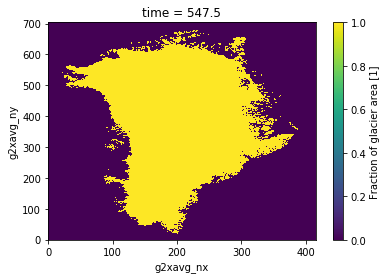

In [23]:
xgIceCov.plot()

All glacier points (`xgIceCov`) fall within the ice sheet model domain (`xgIceMask`):

In [24]:
foo = xgIceCov * xgIceMask
np.allclose(xgIceCov.values, foo.values)

True

**Global domain**
<br>
CLM's `PCT_LANDUNIT(3)` has already been imported as `plu`.  We are comparing this to the coupler-L field `x2lavg_Sg_ice_coveredXX` where `XX` runs from `01` to `10`(the bare land class `00` is omitted). This is similar to what is done in `glc2lndMod.F90`:

```fortran
area_ice_mec = sum(this%frac_grc(g, 1:maxpatch_glcmec))
```

In [25]:
xlIceCov = np.ma.zeros((48, 96))
varname_pattern = 'x2lavg_Sg_ice_covered{ec:02d}'

for i in range(1,11):
    varname = varname_pattern.format(ec=i)
    xlIceCov += ds2x[varname].squeeze().to_masked_array()

In [65]:
np.allclose(xlIceCov, plu.values * 0.01)

False

This is to be expected, since `PCT_LANDUNIT(3)` reflects the glacier coverage globally, whereas `x2lavg_Sg_ice_coveredXX` only contains glaciers over the CISM domain. 

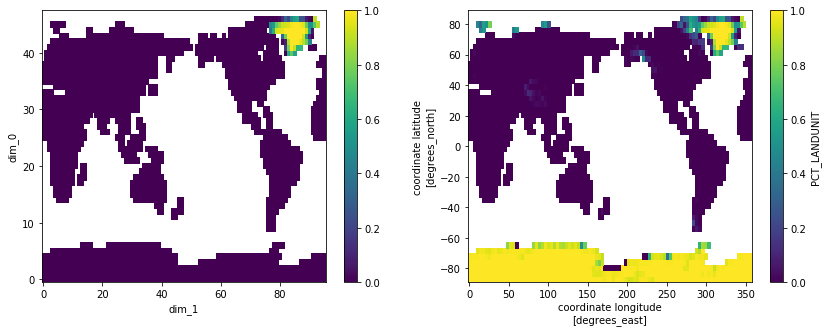

In [66]:
fig, axes = plt.subplots(ncols=2, figsize=(14,5))
xr.DataArray(xlIceCov).plot(ax=axes[0])
xr.DataArray(plu*0.01).plot(ax=axes[1])

However, when we put zeroes in all locations where the coupler field is zero, we see that they are equal:

In [61]:
AA = xlIceCov
BB = xr.where(xlIceCov == 0, 0, plu * 0.01)
np.allclose(AA, BB)

True

Alternatively, we can also multiply by the "ice sheet grid mask" `ICE_MODEL_FRACTION` to obtain equality:

In [63]:
AA = xlIceCov * xlIceMask.to_masked_array()
BB = plu * imf * 0.01
np.allclose(AA, BB)

True

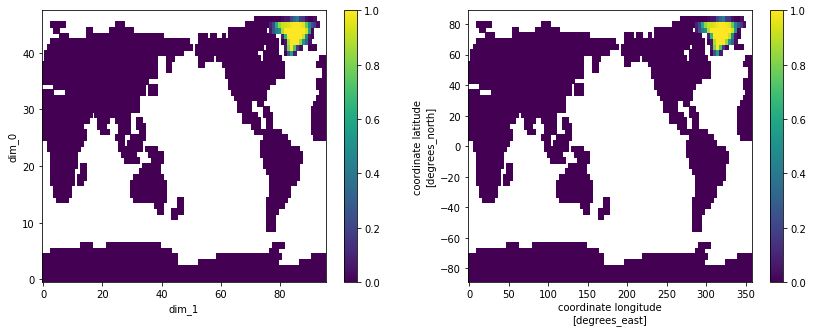

In [67]:
fig, axes = plt.subplots(ncols=2, figsize=(14,5))
xr.DataArray(AA).plot(ax=axes[0])
xr.DataArray(BB).plot(ax=axes[1])

**TODO / QUESTION** 
<br>I observed that `x2lavg_Sg_ice_covered00` has values > 0 , but this elevation class is in fact representing bare land / tundra. I am guessing that these values therefore mean the following: "X % of the grid cell is covered by tundra", but this is not really intuitive since the variable name is `Sg_ice_covered`. 

**Conservation**
<br>

CPL-G field

In [41]:
#(xgIceCov.values * glc_area_km1.values).sum()
(xgIceCov.values * glc_area_km2.values).sum()

1812254.1880229723

CPL-L field

In [55]:
(xlIceCov * lnd_area_km.values ).sum().item()

2321410.824828118

CPL-L field, normalized by `ICE_MODEL_FRACTION`

In [54]:
(xlIceCov * xlIceMask * lnd_area_km).sum().item()

1819528.4080880638

CLM field,  normalized by `ICE_MODEL_FRACTION`

In [48]:
(plu * 0.01 * imf * lnd_area_km.values ).sum().item()

1819527.190504868

CLM field,  normalized by `min(ICE_MODEL_FRACTION, landfrac)`

In [74]:
(plu * 0.01 * min_lf * lnd_area_km.values ).sum().item()

1800944.8967250849

Like the ice sheet grid mask (`ICE_MODEL_FRACTION`) above, glacier coverage appears not to be conserved across model components. With the caveat that the field used for normalization (`ICE_MODEL_FRACTION`), itself was not conserved. 

## Surface mass balance

SMB (in kg m$^{-2}$ s$^{-1}$) is passed from CLM to CISM to tell where ice is growing / melting. There is a bilinear interpolation from the coarse resolution CLM grid and elevation classes, to the fine resolution CISM grid (details in the [User Guide](https://escomp.github.io/cism-docs/cism-in-cesm/versions/release-cesm2.0/html/clm-cism-coupling.html#remapping-surface-mass-balance-from-clm-to-cism)). 

SMB should be conserved: 
> For any ice sheet defined by a CISM domain, the sum over CLM grid cells of the SMB sent to the coupler is equal (within machine roundoff) to the sum over CISM grid cells of the SMB received from the coupler. Note that this is a global (i.e., whole-ice-sheet) rather than a local requirement.

whenever SMB normalization has been turned on in the coupler: 
> `glc_renormalize_smb = ‘on’`

, which is the case in this T31 run (by default, this is _NOT_ the case in one-way coupled runs). 

* CLM has two smb fields, `QICE_FORC` which is splitted out per EC, and `QICE`, which is the grid cell average.
* In the coupler, this is translated into `l2x_Flgl_qice01`, ... which is splitted out per EC
* The remapped field is called `x2g_Flgl_qice` 
* Finally, in CISM the SMB is found in the history output as `smb`




**Global domain**
<br>
CLM has two smb fields, `QICE_FORC` which is splitted out per EC, and `QICE`, which is the grid cell average.

We will first examine how QICE integrates over the GrIS. Further up in the notebook we defined two different CLM GrIS masks.
* mask A: `imf * plu * 0.01`
* mask B: `min_lf * plu * 0.01`

where `imf` is `ICE_MODEL_FRACTION`, `plu` is `PCT_LANDUNIT(3)`, and `min_lf` is the expression `min(landfrac, ICE_MODEL_FRACTION`). The multiplication with 0.01 was necessary to convert a percentage into a fraction. 

Note that up to this point it is unclear whether these are the right definitions to integrate over! 

In [34]:
# factor to convert mm/s to Gt/yr
# account for area multiplication km^2
fac = 86400. * 365 / 1.e12 * 1.e6

#mma = gris_mask_B * area

for tag, gris_mask in zip(('A', 'B', 'C'), (gris_mask_A, gris_mask_B, gris_mask_C)):
    mma = gris_mask * area
    tot_area = mma.sum().item()
    tot_smb = (ds2_tmean['QICE'] * mma ).sum().item() * fac
    print('Mask {tag}, area = {area:7.1f}, smb = {smb:3.1f}'.format(tag=tag, area=tot_area, smb=tot_smb))

Mask A, area = 1819527.2, smb = 892.3
Mask B, area = 1800944.9, smb = 884.7
Mask C, area = 2180684.2, smb = 943.6


**Local domain**
<br>
On the ice sheet domain, we have the coupler field  `x2gavg_Flgl_qice` and CISM field `smb`.

In [35]:
gSmb = ds2g['smb'].squeeze() # land_ice_surface_specific_mass_balance (mm/yr w.e.)
xgSmb = ds2x['x2gavg_Flgl_qice'].squeeze() * sec_in_year # ice_flux_out_of_glacier (kg m-2 s-1)

In [36]:
np.allclose(xgSmb.to_masked_array(), gSmb.to_masked_array())

False

The coupler field `x2gavg_Flgl_qice` appears to have different units than it claims to be having. I've converted the units from kg/m2/s to kg/m2 but these values are still way too small...

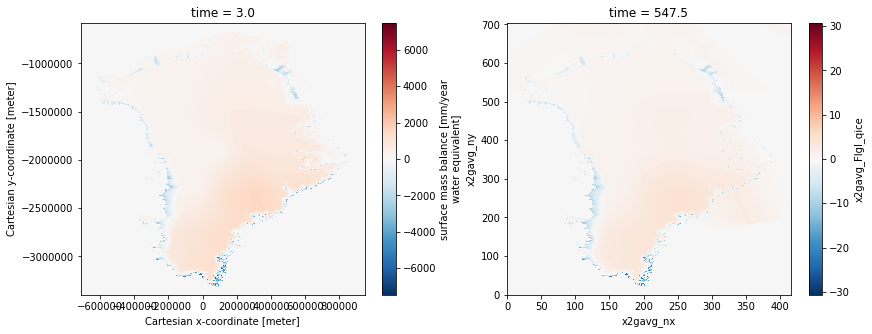

In [37]:
fig, axes = plt.subplots(ncols=2, figsize=(14,5))
xr.DataArray(gSmb).plot(ax=axes[0])
xr.DataArray(xgSmb).plot(ax=axes[1])

This could be an artifact of the fact that SMB is only sent from the coupler to CISM once a year (assuming the coupling frequency is one year), and this coupler field is the *average* flux over a year. Not sure what that means in this context...

Anyway, we can now integrate SMB over the CISM domain, using `smb` from the CISM history output:

In [38]:
# factor to convert mm/yr to Gt/yr
# account for area multiplication km^2
fac = 1.e-12 * 1.e6

area_gIceMask = (glc_area_km2.values * gIceMask.values).sum()
area_gIceCov  = (glc_area_km2.values * gIceCov.values).sum()

smb_gIceMask  = (gSmb * glc_area_km2.values * gIceMask.values).sum().item() * fac
smb_gIceCov   = (gSmb * glc_area_km2.values * gIceCov.values).sum().item() * fac

print('Entire domain, area = {area:7.1f}, smb = {smb:3.1f}'.format(area=area_gIceMask, smb=smb_gIceMask))
print('Ice covered, area = {area:7.1f}, smb = {smb:3.1f}'.format(area=area_gIceCov, smb=smb_gIceCov))

Entire domain, area = 2191143.2, smb = 924.3
Ice covered, area = 1812254.2, smb = 881.8
